In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *
import folium 
from shapely.geometry import Point, Polygon

In [ ]:
df_OH = pd.read_csv('01.운영이력.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 데이터 가공

#### 전체 이용 현황

In [ ]:
df_OH

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
0,15945541,2,2017-01-01 00:00:41,213,18,2017-01-01 00:13:52,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN
1,15945542,2,2017-01-01 00:01:03,231,4,2017-01-01 00:50:24,231,17,31039.0,1,187551,0.0,1A844000000494,NaN
2,15945543,2,2017-01-01 00:01:50,119,14,2017-01-01 01:01:50,0,0,NaN,12,168994,0.0,1A844000000533,1.0
3,15945544,2,2017-01-01 00:02:09,121,17,2017-01-01 00:15:58,133,14,15490.0,12,183971,0.0,1A844000000731,NaN
4,15945545,2,2017-01-01 00:03:32,320,29,2017-01-01 00:18:44,259,27,0.0,12,167475,0.0,1A84400000F343,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142683,21718608,2,2019-12-31 23:52:39,222,16,2019-12-31 23:58:56,219,24,0.0,3,236957,0.0,1A84400000F881,NaN
3142684,21718610,2,2019-12-31 23:53:59,343,14,2019-12-31 23:57:59,311,15,0.0,99,0,4124665.0,1A84400000F9DA,NaN
3142685,21718611,2,2019-12-31 23:55:27,333,17,2020-01-01 00:06:24,322,5,0.0,99,0,4124667.0,1A84400000048B,NaN
3142686,21718613,2,2019-12-31 23:59:14,264,4,2020-01-01 00:10:39,210,13,0.0,12,180671,0.0,1A84400000F804,NaN


In [ ]:
# 시간을 계산하기 위해 'LEAS_DATE','RTN_DATE'두개의 컬럼을 '년월일시분초' 형식으로 변경하여 준다 
df_OH['LEAS_DATE'] =  pd.to_datetime(df_OH['LEAS_DATE'], format='%Y-%m-%d %H:%M:%S', errors='raise') 
df_OH['RTN_DATE'] =  pd.to_datetime(df_OH['RTN_DATE'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [ ]:
# 'RTN_DATE' - 'LEAS_DATE 를 통해 새로운 컬럼 초단위를 기준으로 하는 'Biek_Time(s)' 컬럼을 만들어 준다.
df_OH['Bike_Time(s)'] = df_OH['RTN_DATE'] - df_OH['LEAS_DATE'] # 이용 시간 Column 추가
df_OH['Bike_Time(s)'] = df_OH['Bike_Time(s)'].dt.total_seconds() #초단위로 나타내 준다.

In [ ]:
df_OH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142688 entries, 0 to 3142687
Data columns (total 15 columns):
 #   Column        Dtype         
---  ------        -----         
 0   LEAS_NO       int64         
 1   LEAS_STAT     int64         
 2   LEAS_DATE     datetime64[ns]
 3   LEAS_STATION  int64         
 4   LEAS_DEF_NO   int64         
 5   RTN_DATE      datetime64[ns]
 6   RTN_STATION   int64         
 7   RTN_DEF_NO    int64         
 8   TRNV_QTY      float64       
 9   MEMB_DIV      object        
 10  MEMB_NO       int64         
 11  TEMP_MEMB_NO  float64       
 12  BIKE_TAG      object        
 13  RTN_PROCESS   float64       
 14  Bike_Time(s)  float64       
dtypes: datetime64[ns](2), float64(4), int64(7), object(2)
memory usage: 359.7+ MB


In [ ]:
df_OH['LEAS_DATE'] = df_OH[['LEAS_DATE']].astype(str)
df_OH['RTN_DATE'] = df_OH[['RTN_DATE']].astype(str)

In [ ]:
# 시간별 회수를 구하기 위해 컬럼의 내용을 시간 단위로 바꿔준다.
df_OH['LEAS_DATE']=df_OH['LEAS_DATE'].apply(lambda x : x[11:13]) 
df_OH['RTN_DATE']=df_OH['RTN_DATE'].apply(lambda x : x[11:13])

In [ ]:
df_OH

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,Bike_Time(s)
0,15945541,2,00,213,18,00,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,791.0
1,15945542,2,00,231,4,00,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2961.0
2,15945543,2,00,119,14,01,0,0,NaN,12,168994,0.0,1A844000000533,1.0,3600.0
3,15945544,2,00,121,17,00,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,829.0
4,15945545,2,00,320,29,00,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142683,21718608,2,23,222,16,23,219,24,0.0,3,236957,0.0,1A84400000F881,NaN,377.0
3142684,21718610,2,23,343,14,23,311,15,0.0,99,0,4124665.0,1A84400000F9DA,NaN,240.0
3142685,21718611,2,23,333,17,00,322,5,0.0,99,0,4124667.0,1A84400000048B,NaN,657.0
3142686,21718613,2,23,264,4,00,210,13,0.0,12,180671,0.0,1A84400000F804,NaN,685.0


### 3년간 시간별 자전거 스테이션 이용 현황

#### 회원 이용 현황

In [ ]:
df_OH_Mem = df_OH[df_OH['MEMB_NO']!= 0] #  회원들만 뽑아내 준다.
df_OH_Mem

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,Bike_Time(s)
0,15945541,2,00,213,18,00,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,791.0
1,15945542,2,00,231,4,00,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2961.0
2,15945543,2,00,119,14,01,0,0,NaN,12,168994,0.0,1A844000000533,1.0,3600.0
3,15945544,2,00,121,17,00,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,829.0
4,15945545,2,00,320,29,00,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142681,21718606,2,23,309,16,23,343,16,0.0,3,26784,0.0,1A84400000F175,NaN,310.0
3142682,21718607,2,23,210,13,00,316,1,0.0,2,235729,0.0,1A84400000F90F,NaN,1874.0
3142683,21718608,2,23,222,16,23,219,24,0.0,3,236957,0.0,1A84400000F881,NaN,377.0
3142686,21718613,2,23,264,4,00,210,13,0.0,12,180671,0.0,1A84400000F804,NaN,685.0


In [ ]:
time_list = df_OH['LEAS_DATE'].unique().tolist() # 리스트로 변환
df_time_list = pd.DataFrame(time_list, columns=['Hour'])

#### 3년간 시간별 자전거 스테이션 이용 현황

In [ ]:
# 3년간 시간대별 자전거 이용 Count
Hour_bike_station_Count = []
for i in tqdm(time_list):
    Hour_bike_station_Count.append(df_OH['LEAS_DATE'].apply(lambda x: x.count(i)).sum())

In [ ]:
# 데이터 프레임
df_Hour_bike_station_Count = pd.DataFrame(Hour_bike_station_Count, columns=['시간별 자전거 이용 횟수'])
df_Hour_bike_station_all = pd.concat([df_time_list,df_Hour_bike_station_Count], axis=1)
df_Hour_bike_station_all

,Hour,시간별 자전거 이용 횟수
0,00,99789
1,01,75957
2,02,52723
3,03,31058
4,04,21666
5,05,28283
6,06,51563
7,07,107239
8,08,186510
9,09,115482


#### 3년간 시간별 회원 자전거 스테이션 이용 현황

In [ ]:
# 3년간 시간대별 회원 자전거 이용 Count
Hour_bike_station_Count_Mem = []
for i in tqdm(time_list):
    Hour_bike_station_Count_Mem.append(df_OH_Mem['LEAS_DATE'].apply(lambda x: x.count(i)).sum())

In [ ]:
# 데이터 프레임
df_Hour_bike_station_Count_Mem = pd.DataFrame(Hour_bike_station_Count_Mem, columns=['시간별 회원 자전거 이용 횟수'])
df_Hour_bike_station_Mem_1 = pd.concat([df_time_list,df_Hour_bike_station_Count_Mem], axis=1)
df_Hour_bike_station_Mem = df_Hour_bike_station_Mem_1[['시간별 회원 자전거 이용 횟수']]
df_Hour_bike_station_Mem

,시간별 회원 자전거 이용 횟수
0,64547
1,46597
2,30962
3,17358
4,13096
5,22366
6,45460
7,96772
8,168084
9,98288


#### dataframe merge 및 비회원 이용 횟수 까지 구하기

In [ ]:
df_Hour_bike_station_all_data = pd.concat([df_Hour_bike_station_all,df_Hour_bike_station_Mem],axis=1)

In [ ]:
df_Hour_bike_station_all_data_end = df_Hour_bike_station_all_data.assign(TEST=lambda x: (x['시간별 자전거 이용 횟수']-x['시간별 회원 자전거 이용 횟수']))
df_Hour_bike_station_all_data_end.columns = ['Hour','시간별 자전거 이용 횟수','시간별 회원 자전거 이용 횟수','시간별 비회원 자전거 이용 횟수']
df_Hour_bike_station_all_data_end

,Hour,시간별 자전거 이용 횟수,시간별 회원 자전거 이용 횟수,시간별 비회원 자전거 이용 횟수
0,00,99789,64547,35242
1,01,75957,46597,29360
2,02,52723,30962,21761
3,03,31058,17358,13700
4,04,21666,13096,8570
5,05,28283,22366,5917
6,06,51563,45460,6103
7,07,107239,96772,10467
8,08,186510,168084,18426
9,09,115482,98288,17194


### 시간 단위를 기준으로 스테이션 이용 현황

In [ ]:
df_OH

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,Bike_Time(s)
0,15945541,2,00,213,18,00,260,17,0.0,6,164203,0.0,1A844000000BB7,NaN,791.0
1,15945542,2,00,231,4,00,231,17,31039.0,1,187551,0.0,1A844000000494,NaN,2961.0
2,15945543,2,00,119,14,01,0,0,NaN,12,168994,0.0,1A844000000533,1.0,3600.0
3,15945544,2,00,121,17,00,133,14,15490.0,12,183971,0.0,1A844000000731,NaN,829.0
4,15945545,2,00,320,29,00,259,27,0.0,12,167475,0.0,1A84400000F343,NaN,912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142683,21718608,2,23,222,16,23,219,24,0.0,3,236957,0.0,1A84400000F881,NaN,377.0
3142684,21718610,2,23,343,14,23,311,15,0.0,99,0,4124665.0,1A84400000F9DA,NaN,240.0
3142685,21718611,2,23,333,17,00,322,5,0.0,99,0,4124667.0,1A84400000048B,NaN,657.0
3142686,21718613,2,23,264,4,00,210,13,0.0,12,180671,0.0,1A84400000F804,NaN,685.0


In [ ]:
# 시간별 대여 스테이션 이용 현황을 구해 줄 수 있다.
df_Hour_Station_re = (df_OH.groupby([df_OH['LEAS_DATE'],df_OH['LEAS_STATION']])).count()
df_Hour_Station_1 = df_Hour_Station_re['RTN_STATION']
df_Hour_Station_rent = df_Hour_Station_1.reset_index()
df_Hour_Station_rent.columns = ['LEAS_DATE','LEAS_STATION','LEAS_STATION_Count']
df_Hour_Station_rent

,LEAS_DATE,LEAS_STATION,LEAS_STATION_Count
0,00,101,333
1,00,103,214
2,00,104,605
3,00,105,118
4,00,106,346
...,...,...,...
3719,23,348,228
3720,23,349,244
3721,23,350,162
3722,23,351,16


In [ ]:
# 시간별 반납 스테이션 이용 현황을 구해 줄 수 있다.
df_Hour_Station_ret = (df_OH.groupby([df_OH['LEAS_DATE'],df_OH['RTN_STATION']])).count()
df_Hour_Station_2 = df_Hour_Station_ret['LEAS_STATION']
df_Hour_Station_return = df_Hour_Station_2.reset_index()
df_Hour_Station_return.columns = ['LEAS_DATE','RTN_STATION','RTN_STATION_Count']
df_Hour_Station_return

,LEAS_DATE,RTN_STATION,RTN_STATION_Count
0,00,0,14687
1,00,101,385
2,00,103,466
3,00,104,469
4,00,105,137
...,...,...,...
3746,23,349,458
3747,23,350,213
3748,23,351,23
3749,23,992,6


### 전체 시간별 이용 횟수 데이터 시각화


In [ ]:
df_Hour_bike_station_all_data_end['Hour']tlr=df_Hour_bike_station_all_data_end[['Hour']].astype('str') # 그래프를 정확하게 나타내기 위해 int를 str로 변경해 준다.

In [ ]:
df_Hour_bike_station_all_data_end.describe()

,시간별 자전거 이용 횟수,시간별 회원 자전거 이용 횟수,시간별 비회원 자전거 이용 횟수
count,24.000000,24.00000,24.000000
mean,130945.333333,97929.12500,33016.208333
std,66570.566969,51290.22457,18569.609745
min,21666.000000,13096.00000,5917.000000
25%,93831.000000,60059.50000,18118.000000
50%,125250.000000,98521.00000,31385.500000
75%,187035.750000,135858.00000,51519.000000
max,258162.000000,196508.00000,61654.000000


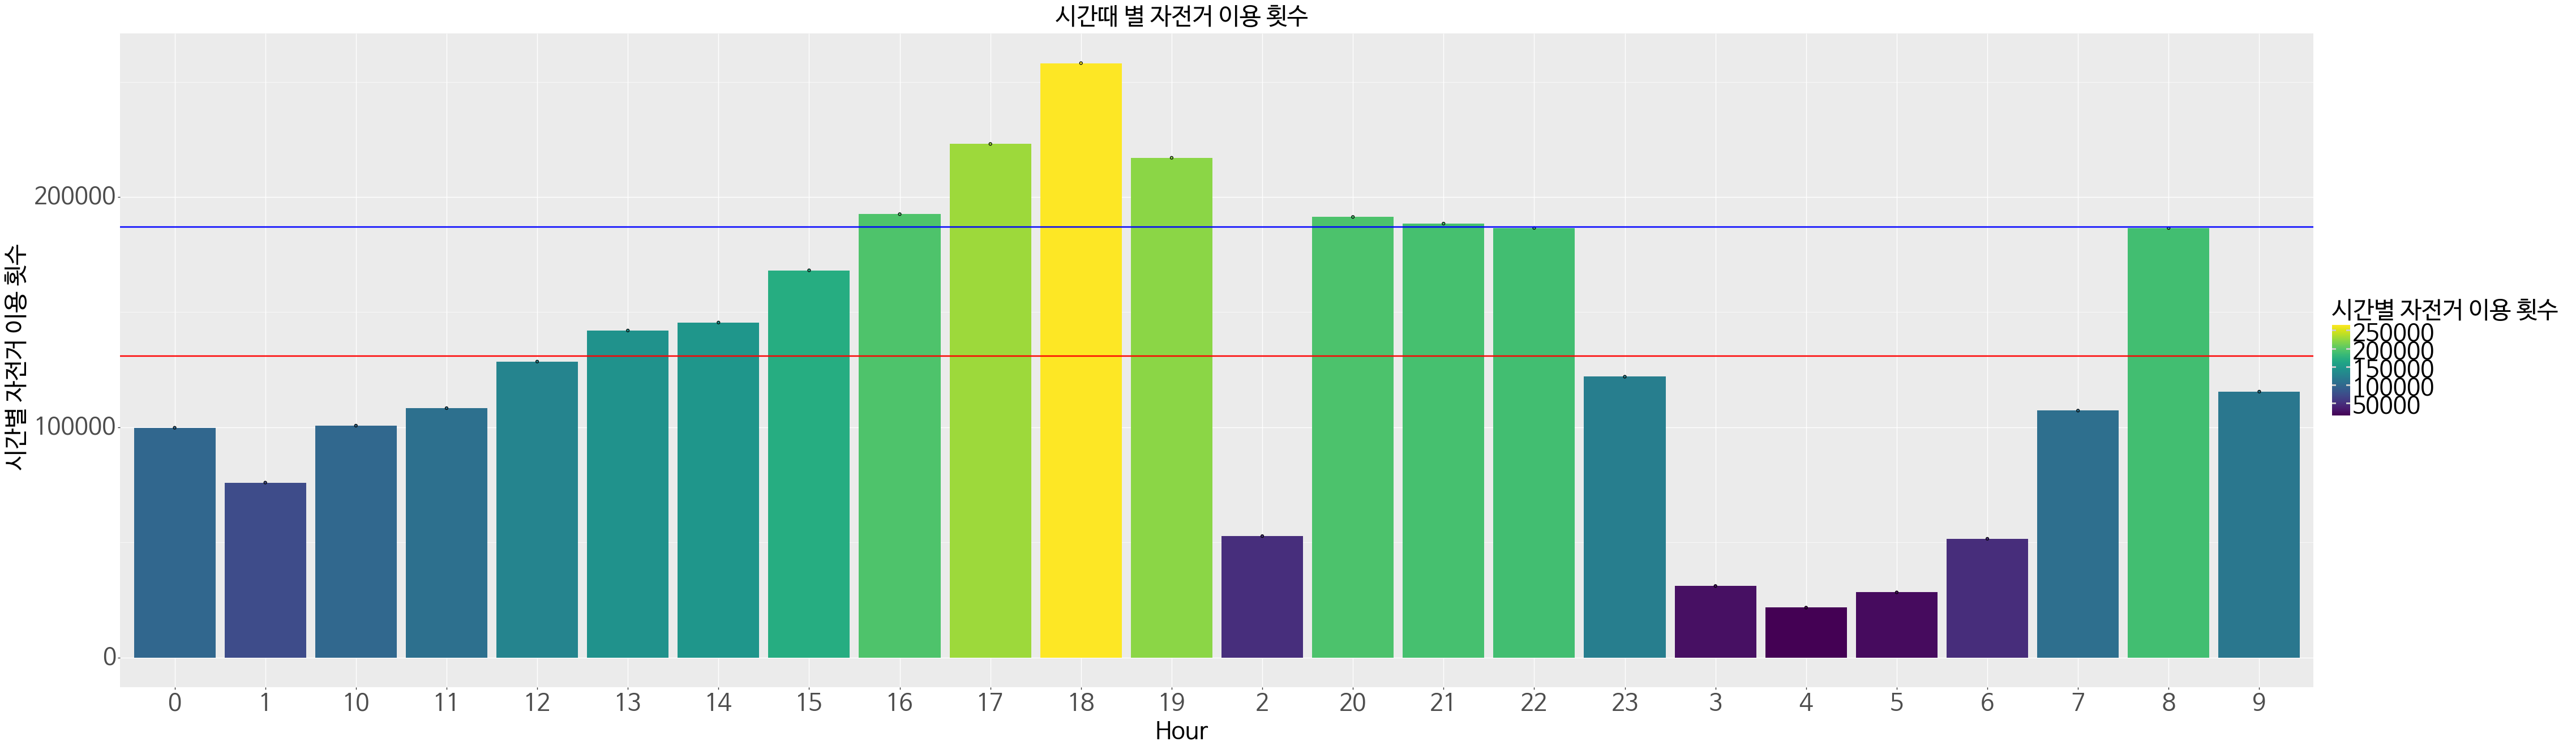

<ggplot: (8751664677391)>

In [ ]:
(ggplot(df_Hour_bike_station_all_data_end)
+ aes(x = 'Hour', y = '시간별 자전거 이용 횟수', fill = '시간별 자전거 이용 횟수')
+ geom_bar(stat = 'identity') 
+ geom_point()
+ geom_hline(yintercept = 130945.333333,color='red',size=1) # 시간별 자전거 이용 횟수 평균
 + geom_hline(yintercept = 187035.750000,color='blue',size=1) # quantil_75
+ labs(x='Hour', y='시간별 자전거 이용 횟수', title = '시간때 별 자전거 이용 횟수')
+ theme(text = element_text(family = "NanumBarunGothic", size=30), figure_size = (50,15)) 
)
